In [25]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings

warnings.filterwarnings('ignore')
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [26]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [27]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

In [28]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [29]:
non_numeric_columns = weather_df.select_dtypes([object]).columns
print(non_numeric_columns)
print('The number of non numeric columns is {}'.format(len(non_numeric_columns)))

Index(['summary', 'preciptype', 'dailysummary'], dtype='object')
The number of non numeric columns is 3


In [30]:
numeric_columns = weather_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print('The numer of numeric columns is {}'.format(len(numeric_columns)))

Index(['temperature', 'apparenttemperature', 'humidity', 'windspeed',
       'windbearing', 'visibility', 'loudcover', 'pressure'],
      dtype='object')
The numer of numeric columns is 8


In [31]:
total_missing = weather_df.isnull().sum().sort_values(ascending=False)
percent_missing = (weather_df.isnull().sum())/(weather_df.isnull().count
()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis =1, keys = [
'Total', 'Percent'])
missing_data.head(10)

,Total,Percent
dailysummary,0,0.0
pressure,0,0.0
loudcover,0,0.0
visibility,0,0.0
windbearing,0,0.0
windspeed,0,0.0
humidity,0,0.0
apparenttemperature,0,0.0
temperature,0,0.0
preciptype,0,0.0


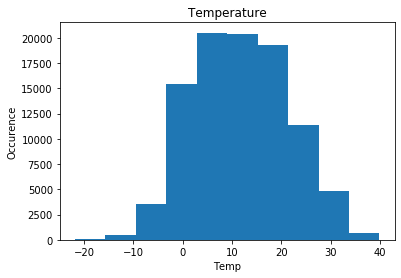

In [32]:
plt.hist(weather_df.temperature)
plt.title('Temperature')
plt.xlabel('Temp')
plt.ylabel('Occurence')
plt.show()

In [34]:
np.abs(weather_df[numeric_columns].iloc[:,0:].corr().loc[:,'temperature']).sort_values(ascending=False)

temperature            1.000000
apparenttemperature    0.992629
humidity               0.632255
visibility             0.392847
windbearing            0.029988
windspeed              0.008957
pressure               0.005447
loudcover                   NaN
Name: temperature, dtype: float64

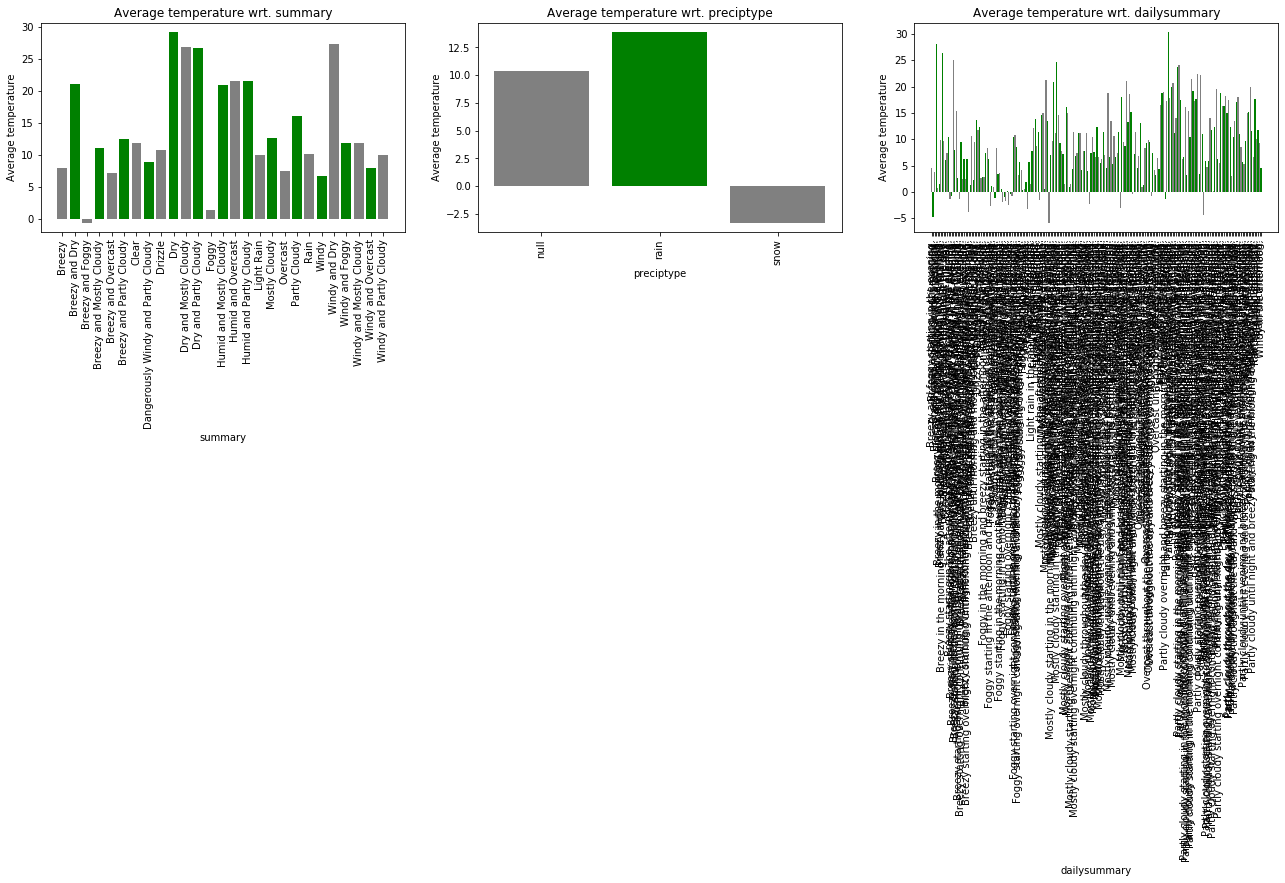

In [35]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(weather_df.groupby(column)["temperature"].mean().index, weather_df.groupby(column)["temperature"].mean(),
           color=("grey","green"))
    plt.title("Average temperature wrt. {}".format(column))
    plt.ylabel("Average temperature")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [37]:
weather_df = pd.concat([weather_df,pd.get_dummies(weather_df.summary, prefix="summary", drop_first=True)], axis=1)
weather_df = pd.concat([weather_df,pd.get_dummies(weather_df.preciptype, prefix="preciptype", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df.summary, prefix="summary", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(weather_df.preciptype, prefix="preciptype", drop_first=True).columns)

In [49]:
X = weather_df[['humidity', 'windbearing', 'windspeed', 'pressure']] #+ dummy_column_names]

y = weather_df.temperature


In [50]:
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Sun, 19 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:56:14   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Coefficients: 
 [2. 3.]

Intercept: 
 0.999999999650754


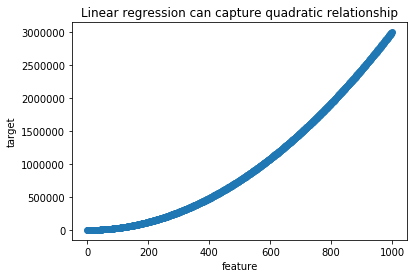

In [51]:
df = pd.DataFrame()

# data from 0 to 999
df["X"] = np.arange(0,1000,1)
# we take the square of X
df["X_sq"] = df["X"]**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df["Y"] = 1 + 2*df["X"] + 3*df["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df[["X","X_sq"]],df["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()
#LRM correctly estimated the true coefficients and captrued the relationship

In [55]:
lrm = linear_model.LinearRegression()
lrm.fit(X, y)
predictions = lrm.predict(X)
errors = y - predictions

print("Mean of the errors in the Temperature model is: {}".format(np.mean(errors)))

#Effectively zero

Mean of the errors in the Temperature model is: -7.614799564418127e-15


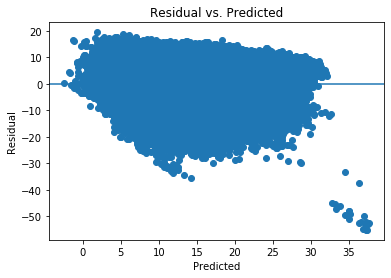

In [56]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
#Seems fairly homoscedastic

In [57]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))
#lower than 0.05. Reject the null. Errors are heteroscedastic

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


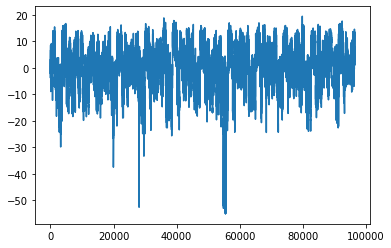

In [58]:
plt.plot(errors)
plt.show()
#seems uncorrelated

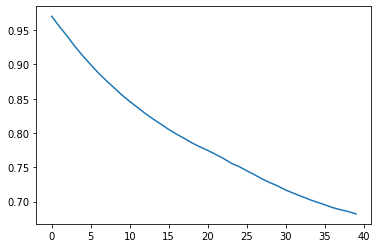

In [59]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()
#autocorrelation is fairly low. (0.68 and 0.98)

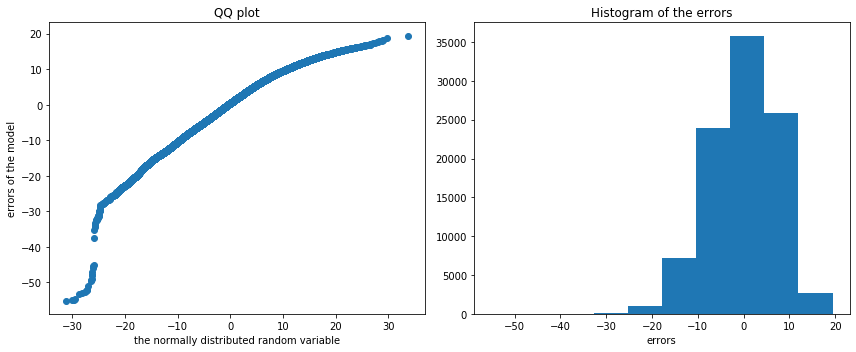

In [60]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()
#errors are not normally distribbued exactly
#Graphs imply distribution is not far from normal

In [61]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [62]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
#pvalues show errors are not normally distributed

Jarque-Bera test statistics is 3793.2967352523365 and p value is 0.0
Normality test statistics is 3375.4323076995624 and p value is 0.0


In [ ]:
#Gauss-Markov Conditions met?
